In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA
import scipy.io as sio
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ### select either 0 or 1
print(f'Using device: {device}')
import statsmodels.api as sm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Using device: cuda:0


In [2]:
dur = 40
iterations = 5000
output_dimension = 3
cebra_veldir_model = CEBRA(model_architecture='offset1-model',
                           batch_size=512,
                           learning_rate = 0.0001,
                           temperature = 1,
                           output_dimension = output_dimension,
                           max_iterations=iterations,
                           distance='cosine',
                           conditional='time_delta',
                           device="cuda:1", ### 'cuda_if_available'
                           verbose=True,
                           time_offsets=1)
def split_data(neural, continuous_index, train_trial):
            split_idx = train_trial*dur 
            neural_train = neural[:split_idx]
            neural_test = neural[split_idx:]
            continuous_index_train = continuous_index[:split_idx]
            continuous_index_test = continuous_index[split_idx:]
            return neural_train,neural_test,continuous_index_train,continuous_index_test
        
angle_to_new_value = {-180: 4,-135: 5,-90: 6,-45: 7,0: 0,45: 1,90: 2,135: 3,180: 4}

mat_contents=sio.loadmat("./data_NER/Fig1/Chewie_20161014_neural_con_dis_index.mat") 
neural = mat_contents['neural_M1']
continuous_index_2d = mat_contents['continuous_index']*10
discrete_index = mat_contents['discrete_index']

vectorized_map = np.vectorize(lambda x: angle_to_new_value[x])
discrete_index = vectorized_map(discrete_index)
continuous_index = np.hstack((continuous_index_2d, discrete_index*45))
total_trial = int(discrete_index.shape[0]/dur)
train_trial = int(total_trial*0.8)
test_trial = total_trial-train_trial

neural_train, neural_test, continuous_index_train, continuous_index_test = split_data(neural, continuous_index, train_trial)
target_angle_train = continuous_index_train[:, 2].copy()
cebra_veldir_model.fit(neural_train, continuous_index_train)
cebra_veldir_train = cebra_veldir_model.transform(neural_train)


pos: -0.8855 neg:  6.4074 total:  5.5219 temperature:  1.0000: 100%|█| 5000/5000


In [3]:
directory = "./NER_Figs_pdf/Fig1/"
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
train_loss = cebra_veldir_model.state_dict_['loss']
train_loss_stable = train_loss[-10:].numpy()
ax.plot(train_loss, c='deepskyblue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('RnC Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.title('iterations='+str(iterations)+'  final loss='+str(np.mean(train_loss_stable)))
new_filename = "CEBRA_Chewie_20161014_train_loss_"+str(iterations)+"itr.pdf" 
output_path = os.path.join(directory, new_filename)
plt.savefig(output_path)
plt.close(fig)

X = cebra_veldir_train
y = continuous_index_train[:, 0:2]
initial_positions = np.zeros((train_trial, 1, 2))
velocity_reshaped = y.reshape(train_trial, dur, 2)
displacements = np.cumsum(velocity_reshaped, axis=1)
locations = initial_positions + displacements
pos_truth = locations.reshape(train_trial*dur, 2)
truth_XY = pos_truth[:, 0:2]

LinReg = LinearRegression()
LinReg.fit(X, y) 
pred_vel = LinReg.predict(X) 
LogisticReg = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
LogisticReg.fit(X, target_angle_train)
pred_dir = LogisticReg.predict(X)

velocity_reshaped = pred_vel.reshape(train_trial, dur, 2)
displacements = np.cumsum(velocity_reshaped, axis=1)
locations = initial_positions + displacements
pred_XY = locations.reshape(train_trial*dur, 2)

posi_r2 = r2_score(truth_XY, pred_XY) ### proportion of total variation explained by model
vel_r2 = r2_score(y, pred_vel)

differences = abs(pred_dir - target_angle_train)
angle_diffs = np.where(differences > 180, 360 - differences, differences)
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.scatter(truth_XY[:, 0], truth_XY[:, 1], alpha=1, color=plt.cm.hsv(1/360*target_angle_train), s=0.3)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

ax2 = plt.subplot(122)
ax2.scatter(pred_XY[:, 0], pred_XY[:, 1], alpha=1, color=plt.cm.hsv(1/360*pred_dir), s=0.3)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
plt.title('True vs Pred-R2 vel='+str(round(vel_r2, 3))+' pos='+str(round(posi_r2, 3)))
new_filename = "CEBRA_Chewie_20161014_Decoding_"+str(iterations)+"itr.pdf"
output_path = os.path.join(directory, new_filename)
plt.savefig(output_path)
plt.close(fig)

idx1, idx2, idx3 = 0, 1, 2
fig = plt.figure(figsize=(10, 5), dpi=250)
ax = plt.subplot(121, projection = '3d')
x = ax.scatter(X[:, idx1],
               X[:, idx2],
               X[:, idx3],
               c=target_angle_train/360,
               cmap=plt.cm.hsv,
               edgecolors='none',
               alpha=0.75,
               s=0.3)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = plt.subplot(122, projection = '3d')
for i in range(8):
    direction_trial = (target_angle_train//45 == i)
    trial_avg = X[direction_trial, :].reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:, idx1], 
               trial_avg[:, idx2],
               trial_avg[:, idx3],
               color=plt.cm.hsv(1 / 8 * i),
               edgecolors='none',
               alpha=0.75,
               s=3)
    ax.plot(trial_avg[:, idx1], 
        trial_avg[:, idx2],
        trial_avg[:, idx3],
        color=plt.cm.hsv(1 / 8 * i), 
        linewidth=0.5,
        alpha=0.75)  
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
new_filename = "CEBRA_Chewie_20161014_Embedding_"+str(iterations)+"itr.pdf"
output_path = os.path.join(directory, new_filename)
plt.savefig(output_path)
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


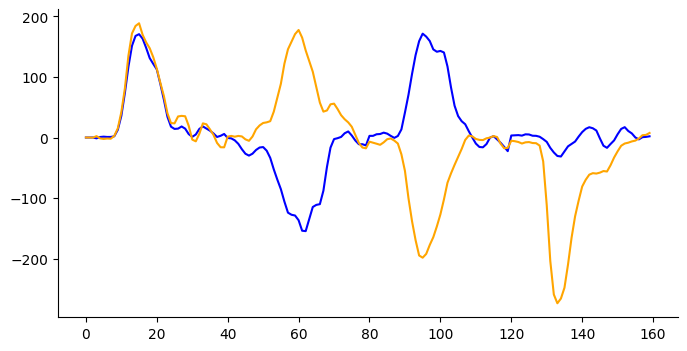

In [4]:
value_range = dur*4

ax = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
ax.plot(1*continuous_index_2d[:value_range, 0], color='blue', label='X-velocity')
ax.plot(1*continuous_index_2d[:value_range, 1], color='orange', label='Y-velocity')
# ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

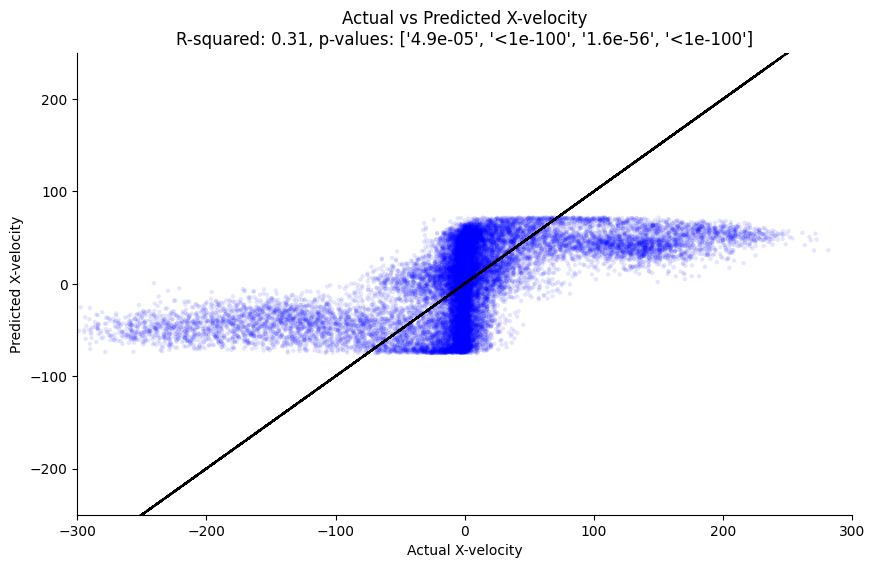

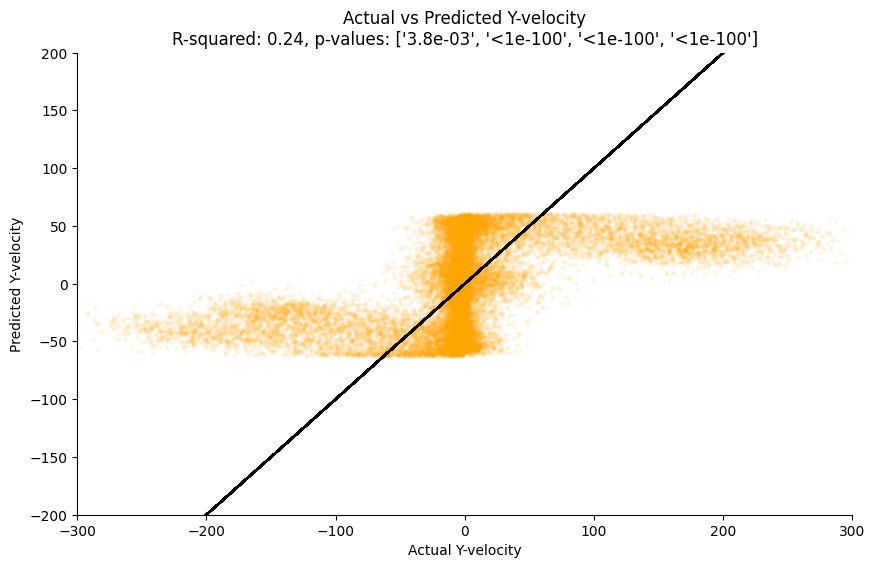

In [5]:
# Fit the model for X-velocity using sklearn
model_x = LinearRegression()
model_x.fit(X, y[:, 0])
y_pred_x = model_x.predict(X)
r2_x = r2_score(y[:, 0], y_pred_x)

# Fit the model for Y-velocity using sklearn
model_y = LinearRegression()
model_y.fit(X, y[:, 1])
y_pred_y = model_y.predict(X)
r2_y = r2_score(y[:, 1], y_pred_y)

# Fit the model for X-velocity using statsmodels to get p-values
X_with_const = sm.add_constant(X)
ols_model_x = sm.OLS(y[:, 0], X_with_const).fit()
p_values_x = ols_model_x.pvalues

# Fit the model for Y-velocity using statsmodels to get p-values
ols_model_y = sm.OLS(y[:, 1], X_with_const).fit()
p_values_y = ols_model_y.pvalues

# Format p-values in scientific notation, with a minimum display value
def format_p_value(p):
    if p < 1e-100:
        return '<1e-100'
    else:
        return f'{p:.1e}'

formatted_p_values_x = [format_p_value(p) for p in p_values_x]
formatted_p_values_y = [format_p_value(p) for p in p_values_y]

# Scatter plot and fitted line for X-velocity
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.scatter(y[:, 0], y_pred_x, s=10, alpha=0.1, marker='o', color='blue', edgecolor='none')
plt.plot(y[:, 0], y[:, 0], 'k--', label='Ideal Fit Line')
title_x = f'Actual vs Predicted X-velocity\nR-squared: {r2_x:.2f}, p-values: {formatted_p_values_x}'
plt.title(title_x)
plt.xlabel('Actual X-velocity')
plt.ylabel('Predicted X-velocity')
plt.xlim(-300, 300)
plt.ylim(-250, 250)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.show()

new_filename = "CEBRA_Chewie_20161014_X_velocity_real_vs_pred_"+str(iterations)+".pdf"
output_path = os.path.join(directory, new_filename)
plt.savefig(output_path)
plt.close(fig)

# Scatter plot and fitted line for Y-velocity
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.scatter(y[:, 1], y_pred_y, s=10, alpha=0.1, marker='o', color='orange', edgecolor='none')
plt.plot(y[:, 1], y[:, 1], 'k--', label='Ideal Fit Line')
title_y = f'Actual vs Predicted Y-velocity\nR-squared: {r2_y:.2f}, p-values: {formatted_p_values_y}'
plt.title(title_y)
plt.xlim(-300, 300)
plt.ylim(-200, 200)
plt.xlabel('Actual Y-velocity')
plt.ylabel('Predicted Y-velocity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

new_filename = "CEBRA_Chewie_20161014_Y_velocity_real_vs_pred_"+str(iterations)+".pdf"
output_path = os.path.join(directory, new_filename)
plt.savefig(output_path)
plt.close(fig)